# CogPonder: N-Back PyTorch Lightning

This notebook implements the CogPonder algorithm using PyTorch Lightning. It assumes fixed hyperparameters and fits the model to a single-subject dataset. It wraps a simple RRN with a pondering lambda layer and trains it on the *Self-Regulation Ontology* dataset.

## Data
The SRO-2back dataset interface provides the following features from the *Self-Regulation Ontology* study:

- `X`: previous 3 symbols for the subject $i$ and trial $j$; For each subject, $X_i$ is a 2-dimensional vector of integers of shape (3, $N_{\text{trials}}$).
- `trial_types`: Correct match, incorrect match, correct-non-match, incorrect-non-match for each trial $i$.
- `is_targets`: whether the trial $i$ is a match; it is a boolean.
- `response`: the response of the subject for the trial i; it is a boolean.
- `response_steps`: the response step of the subject for the trial i; Response step is an integer and represents *response times* in 50ms steps. This step duration is a hyperparameter of the data module.

## Hyperparameters

- `n_embeddings`: number of hidden units in the recurrent ICOM model. Defaults to $N_{\text{symbols} + 1}$
- `lambda_p`: the pondering lambda parameter. Defaults to 0.5.
- `loss_beta`: the beta parameter of the loss function. Defaults to 0.5.
- `learning_rate`: the learning rate of the optimizer. Defaults to 0.0001.
- `max_response_step`: maximum response step in the dataset. Defaults to $\max(\text{response\_step}) + 10$.

## Criterion

$L = L_{\text{reconstruction}} + L_{\text{cognitive}}$


In [1]:
%reload_ext autoreload
%autoreload 3

import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from ray import tune, air
from ray.tune import JupyterNotebookReporter
from functools import partial
from pytorch_lightning.callbacks import RichProgressBar, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from cogponder import CogPonderNet
from cogponder.datasets import NBackMockDataset, NBackDataModule, NBackSRODataset
from pathlib import Path

from cogponder.losses import ReconstructionLoss, CognitiveLoss


In [2]:
# data
data = NBackSRODataset(n_subjects=1, n_back=2) # shape (n_subjects, (...))
datamodule = NBackDataModule(data, batch_size=16)
n_symbols = torch.unique(data[0][0]).shape[0]
max_response_step = data[0][4].max().item() + 1
lambda_p = 1. / data[0][4].median()

# parameter space
CONFIG = {
    'rec_loss_beta': 1.,
    'cog_loss_beta': .0,    
    'loss_by_trial_type': False,
    'learning_rate': 1e-3,
    'max_response_step': max_response_step,
    'lambda_p': lambda_p,
    'inputs_dim': 3,
    'embeddings_dim': n_symbols,
}

CONFIG

{'rec_loss_beta': 1.0,
 'cog_loss_beta': 0.0,
 'loss_by_trial_type': False,
 'learning_rate': 0.001,
 'max_response_step': 16,
 'lambda_p': tensor(0.1250),
 'inputs_dim': 3,
 'embeddings_dim': 5}

In [3]:
# pondering model

model = CogPonderNet(CONFIG, example_input_array=data[0][0][:1])

# # DEBUG
# X = data[0][0][:10]
# y_true = data[0][3][:10]
# rt_true = data[0][4][:10]
# y_steps, p_halts, rt_pred = model(X)
# loss_func = ReconstructionLoss()
# # loss_func = CognitiveLoss(CONFIG['lambda_p'], CONFIG['max_response_step'])
# # l = loss_func(rt_pred, rt_true)

trainer = pl.Trainer(
    max_epochs=100,
    log_every_n_steps=8,
    callbacks=[
        RichProgressBar(),
        EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.01),
    ])

trainer.fit(model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃   ┃ Name           ┃ Type       ┃ Params ┃         In sizes ┃ Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 0 │ halt_node      │ Sequential │      6 │           [1, 5] │    [1, 1] │
│ 1 │ output_node    │ Sequential │      6 │           [1, 5] │    [1, 1] │
│ 2 │ recurrent_node │ GRUCell    │    150 │ [[1, 3], [1, 5]] │    [1, 5] │
└───┴────────────────┴────────────┴────────┴──────────────────┴───────────┘

Trainable params: 162                                                                                              
Non-trainable params: 0                                                                                            
Total params: 162                                                                                                  
Total estimated model params size (MB): 0

Output()

In [12]:
# DEBUG

import torch

X_train, _, y_train, _, rt_train = datamodule.dataset[datamodule.train_dataset.indices]
X_test, _, y_test, _, rt_test = datamodule.dataset[datamodule.test_dataset.indices]

with torch.no_grad():
    model.eval()
    y_train_steps,_,rt_train_pred = model(X_train)
    y_preds,_,rt_test_pred = model(X_test)

    y_pred = y_preds.gather(dim=0, index=rt_test_pred[None, :] - 1,)[0]  # (batch_size,)
    print(y_pred)

    # accuracy = ((y_pred > 0) == y_test.float()).to(torch.float32).mean()
    # print(accuracy, y_test.float().mean())
    # DEBUG report the ground truth and predicted response times
    # print('TRUE TRAIN:', rt_train.detach().tolist(), '\nPRED TRAIN:',  rt_train_pred.tolist())
    # print('TRUE TEST:', rt_test.detach().tolist(), '\nPRED TEST:',  rt_test_pred.tolist())

# DEBUG report medians
# rt_train_pred.median(), rt_train.float().median()
# rt_test_pred.median(), rt_test.float().median()


tensor([0.4403, 0.4613, 0.4403, 0.4937, 0.4403, 0.3282, 0.4403, 0.4403, 0.4403,
        0.4403, 0.3246, 0.4403, 0.2631, 0.3286, 0.2426, 0.3701, 0.4403, 0.3571,
        0.3705, 0.3571, 0.4403, 0.4403, 0.4309, 0.4403, 0.3223, 0.3059, 0.3106,
        0.3984, 0.3843, 0.3040, 0.3301, 0.4403, 0.3070, 0.4403, 0.4403, 0.2882,
        0.4403, 0.4403, 0.4403, 0.3163])


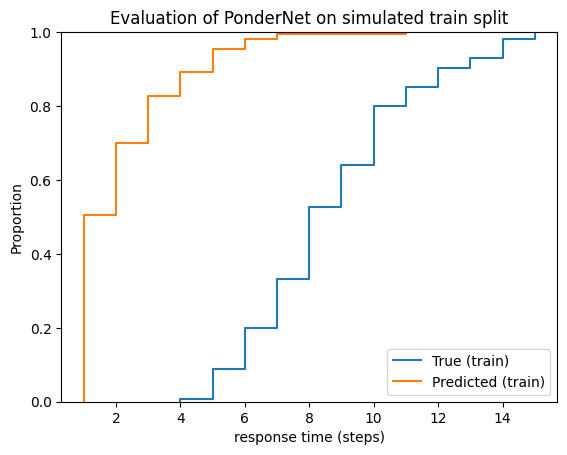

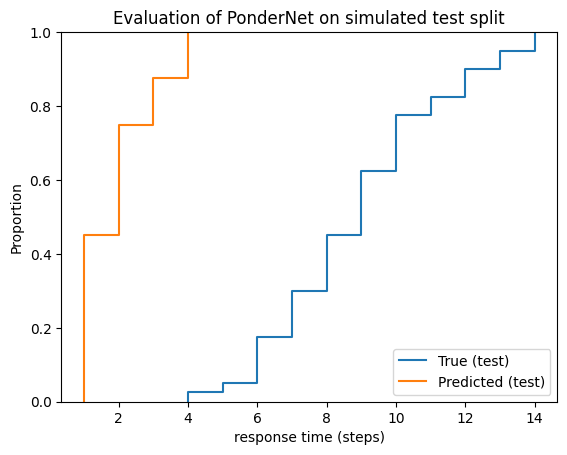

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.ecdfplot(rt_train.detach(), label='True (train)')
sns.ecdfplot(rt_train_pred.detach(), label='Predicted (train)')

plt.title('Evaluation of PonderNet on simulated train split')
plt.xlabel('response time (steps)')

plt.legend()
plt.show()

sns.ecdfplot(rt_test.detach(), label='True (test)')
sns.ecdfplot(rt_test_pred.detach(), label='Predicted (test)')

plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()

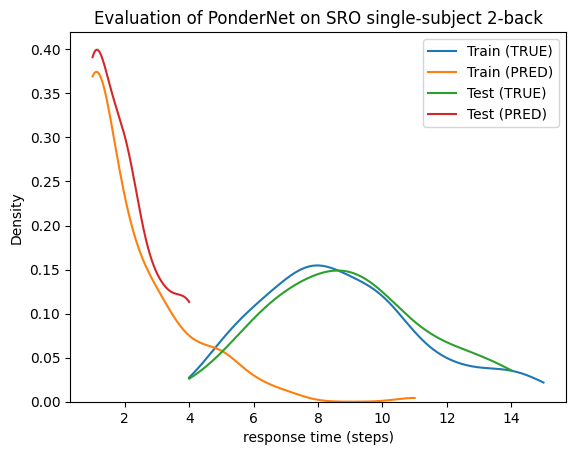

In [14]:

sns.kdeplot(rt_train.detach(), label='Train (TRUE)', cut=0)
sns.kdeplot(rt_train_pred.detach(), label='Train (PRED)', cut=0)

sns.kdeplot(rt_test.detach(), label='Test (TRUE)', cut=0)
sns.kdeplot(rt_test_pred.detach(), label='Test (PRED)', cut=0)


plt.title('Evaluation of PonderNet on SRO single-subject 2-back')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()